## Image segmentation

To devide close particules in single particles we need to do a morphological closing. This means that we need to reconginze the region near the center of the object as the foreground and the region further away from the center as background. 
After that we need to figure out the boundary regions.

In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [9]:
img_3channel = cv2.imread('../example_images/cut_images/zoom/sem_1_cut_zoom2.jpg', 1)

In [10]:
img_3channel.shape

(62, 78, 3)

In [11]:
img = cv2.imread('../example_images/cut_images/zoom/sem_1_cut_zoom2.jpg', 0)

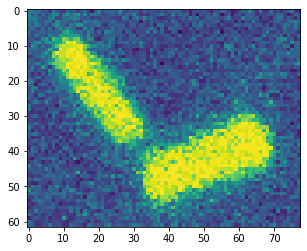

In [12]:
plt.imshow(img)

In [13]:
img.shape

(62, 78)

explain Otsu's thresholding after Gaussian filtering

In [14]:
# Otsu's thresholding after Gaussian filtering
blur = cv2.Gaussian_filter(img,(5,5),0)
ret,th = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

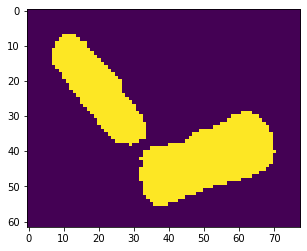

In [15]:
plt.imshow(th)

Since some objects are touching each other, a good option would be to find the distance transform and apply a proper threshold. 

First, we remove all the small noise in the image.



In [16]:
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(th,cv2.MORPH_OPEN,kernel, iterations =4)

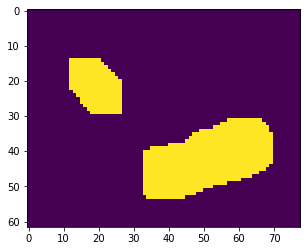

In [17]:
plt.imshow(opening)

Then we need to find the area that for sure is of the background.
We do it by dilatating the particles so that we remove any small holes in the particles.

In [18]:
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=5)

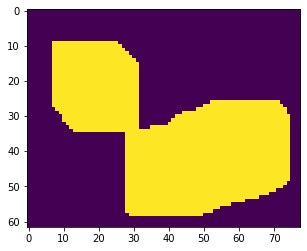

In [19]:
plt.imshow(sure_bg)

Now we need to find the area that is for sure of the particles.

In [20]:
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.1*dist_transform.max(),255,0)

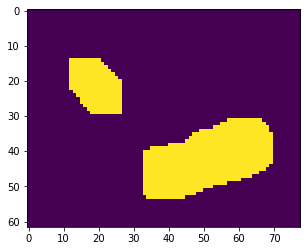

In [21]:
plt.imshow(sure_fg)

Then we substrat the sure background from the sure area of the particles to find the boundaries where the particles touch.

In [22]:
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

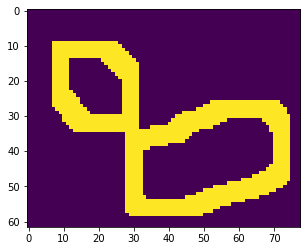

In [23]:
plt.imshow(unknown)

To distinguish which are the region of background and particles we are sure about and which are the boundaries for which we are unsure we use *cv2.connectedComponents()*

In [24]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

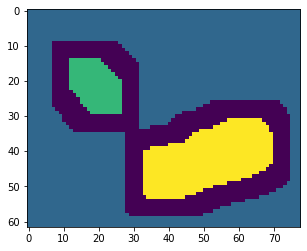

In [25]:
plt.imshow(markers)

In [26]:
markers = cv2.watershed(img_3channel ,markers)

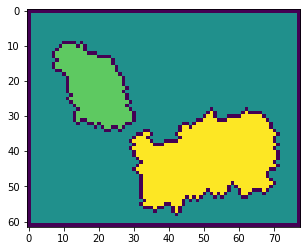

In [27]:
plt.imshow(markers)

In [28]:
markers.shape

(62, 78)

In [29]:
img[markers == -1] = [0]

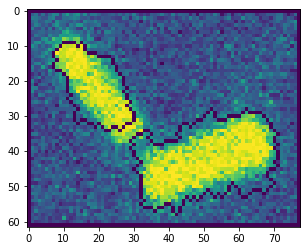

In [30]:
plt.imshow(img)

In [57]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

#Function to calculate the area of borders of two close objects
#The watershed function needs the image and i which define how much of the area of the particle is considered.
#The smaller the i, the larger would be the final boundaries
#The larger the i, the smaller will be the final boundaries

def watershed(image, i = 0.5, o_iter = 5, s_iter = 5):
    img_3channel = cv2.imread(image, 1)
    img = cv2.imread(image, 0)
    blur = cv2.GaussianBlur(img,(5,5),0)
    ret,th = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(th,cv2.MORPH_OPEN,kernel, iterations = o_iter)
    sure_bg = cv2.dilate(opening,kernel,iterations = s_iter)
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform,i*dist_transform.max(),255,0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)
    ret, markers = cv2.connectedComponents(sure_fg) #change name markers --> contours for better explanation
    markers = markers+1
    markers[unknown==255] = 0
    markers = cv2.watershed(img_3channel ,markers)
    img[markers == -1] = [0]
    
    return plt.imshow(img)
    

In [69]:
'''
Iterations for optimization of the parameters?
'''
i_list = np.linspace(0.1,1,10)
o_list = np.linspace(2,10,8)
s_list = np.linspace(2,10,8)

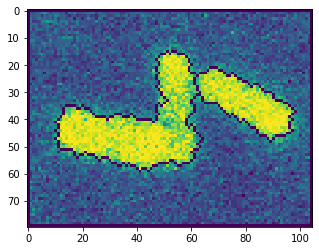

In [59]:
watershed('../example_images/cut_images/zoom/sem_2_cut_zoom.jpg', 0.5, 5, 6)

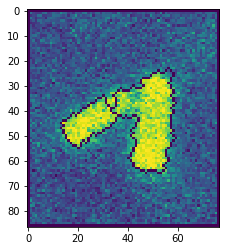

In [63]:
watershed('../example_images/cut_images/zoom/sem_1_cut_zoom.jpg', 0.5,5,6)

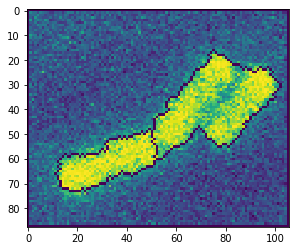

In [53]:
watershed('../example_images/cut_images/zoom/sem_2_cut_zoom2.jpg', 0.66)

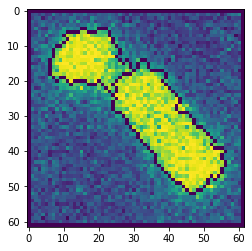

In [54]:
watershed('../example_images/cut_images/zoom/sem_1_cut_zoom3.jpg', 0.7)

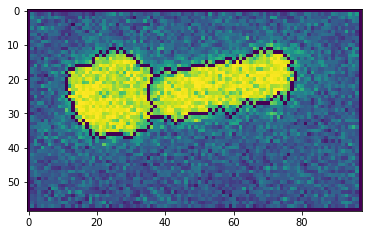

In [56]:
watershed('../example_images/cut_images/zoom/sem_2_cut_zoom3.jpg', 0.6)